# Построение модели, прогнозируещей платёжеспособность клиента в банке.

### Подключение необходимых библиотек, импорт датасета.

In [1]:
%matplotlib inline

# Для работы с данными
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Для препроцессинга
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler 
import sklearn.preprocessing 

# Для интерпретации данных
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder

#Для построения моделей 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import svm

# Для оценки эффективности
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error


from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_excel("DATASET_52.xlsx")

In [3]:
df.sample(5)

,client_id,client_segment,fx_sum,pos_op_sum,med_balance,credit_flag,new_flag,invest_flag,currency,sumrur_op
27240,80799.0,premium,1428102.0,1174856.0,1541059,1.0,0.0,1.0,RUR/USD,1196969
8066,65930.0,standard,820775.0,38958.0,607253,0.0,0.0,0.0,RUR/USD,109062
3718,38173.0,premium,1888912.0,938996.0,1536108,0.0,0.0,1.0,RUR/EUR,755721
2920,96215.0,premium,1944328.0,1451874.0,1159822,0.0,0.0,0.0,USD/RUR,195868
22364,87059.0,standard,113157.0,166455.0,164624,0.0,1.0,1.0,USD/RUR,48815


### Нулевые значения

Проверим наличие нулевых значений.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34987 entries, 0 to 34986
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       34944 non-null  float64
 1   client_segment  34954 non-null  object 
 2   fx_sum          34950 non-null  float64
 3   pos_op_sum      34952 non-null  float64
 4   med_balance     34987 non-null  int64  
 5   credit_flag     34951 non-null  float64
 6   new_flag        34956 non-null  float64
 7   invest_flag     34949 non-null  float64
 8   currency        34952 non-null  object 
 9   sumrur_op       34987 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 2.7+ MB


Нулевые значения присутствуют. Удалим все строки, содержащие пустые ячейки.

In [5]:
df.dropna(axis = 0, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34699 entries, 0 to 34986
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       34699 non-null  float64
 1   client_segment  34699 non-null  object 
 2   fx_sum          34699 non-null  float64
 3   pos_op_sum      34699 non-null  float64
 4   med_balance     34699 non-null  int64  
 5   credit_flag     34699 non-null  float64
 6   new_flag        34699 non-null  float64
 7   invest_flag     34699 non-null  float64
 8   currency        34699 non-null  object 
 9   sumrur_op       34699 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 2.9+ MB


### Строковые значения

In [6]:
df.head(5)

,client_id,client_segment,fx_sum,pos_op_sum,med_balance,credit_flag,new_flag,invest_flag,currency,sumrur_op
0,34601.0,standard,1221604.0,823304.0,226021,0.0,0.0,0.0,RUR/EUR,176062
1,41219.0,premium-online,1777554.0,1097038.0,1487334,0.0,0.0,1.0,RUR/EUR,619594
2,76607.0,standard,353172.0,1020453.0,1174476,1.0,0.0,1.0,USD/RUR,187958
3,62163.0,premium-online,171705.0,200138.0,304929,0.0,0.0,0.0,RUR/EUR,48673
4,9920.0,premium-online,239890.0,269756.0,153423,0.0,0.0,1.0,RUR/USD,36745


Сейчас в нашем датасете есть строковые параметры - client_segment и currency. 
Интерпретируем их как числа.

In [7]:
le = LabelEncoder()


keys = df.client_segment.value_counts().sort_values(ascending=True).index
keys = ['standard', 'premium-online', 'premium']
values = np.array(list(range(len(keys))))+1
mapping = [{
    'col': 'client_segment',
    'mapping': dict(zip(keys, values))
}]
oe = OrdinalEncoder(cols=['client_segment'], mapping=mapping)
df.client_segment = oe.fit_transform(df).client_segment 

le.fit(df['currency'])
df['currency'] = le.transform(df['currency'])
df.head(5)

,client_id,client_segment,fx_sum,pos_op_sum,med_balance,credit_flag,new_flag,invest_flag,currency,sumrur_op
0,34601.0,1,1221604.0,823304.0,226021,0.0,0.0,0.0,1,176062
1,41219.0,2,1777554.0,1097038.0,1487334,0.0,0.0,1.0,1,619594
2,76607.0,1,353172.0,1020453.0,1174476,1.0,0.0,1.0,3,187958
3,62163.0,2,171705.0,200138.0,304929,0.0,0.0,0.0,1,48673
4,9920.0,2,239890.0,269756.0,153423,0.0,0.0,1.0,2,36745


### Выбросы

Идентифицируем выбросы методом межквартильной идентификации и убираем их.

In [8]:
for column in ['fx_sum', 'pos_op_sum', 'med_balance','sumrur_op']:
    print("Removing " + column)
    Q3, Q1 = np.percentile(df[column], [75, 25])
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.50 * IQR
    lower_bound = Q1 - 1.50 * IQR
    print(upper_bound, lower_bound)
    
    df = df[df[column] < upper_bound]
    df = df[df[column] > lower_bound]
    print(len(df))
    print()

Removing fx_sum
2425447.75 -1214074.25
34699

Removing pos_op_sum
2411103.0 -1206453.0
34699

Removing med_balance
2917730.25 -1501947.75
33860

Removing sumrur_op
1066330.625 -561464.375
33545



### Нормализация параметров

In [36]:
for column in ['fx_sum', 'pos_op_sum', 'med_balance', 'sumrur_op']:
    df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(-1,1))

In [37]:
df.head(5)

,client_id,client_segment,fx_sum,pos_op_sum,med_balance,credit_flag,new_flag,invest_flag,currency,sumrur_op
0,34601.0,1,0.621468,0.418661,0.114357,0.0,0.0,0.0,1,0.165144
1,41219.0,2,0.904298,0.557859,0.756126,0.0,0.0,1.0,1,0.581173
2,76607.0,1,0.179667,0.518914,0.596940,1.0,0.0,1.0,3,0.176303
3,62163.0,2,0.087348,0.101773,0.154507,0.0,0.0,0.0,1,0.045655
4,9920.0,2,0.122036,0.137175,0.077419,0.0,0.0,1.0,2,0.034466


# Анализ данных

Построим таблицу корреляций.

<Axes: >

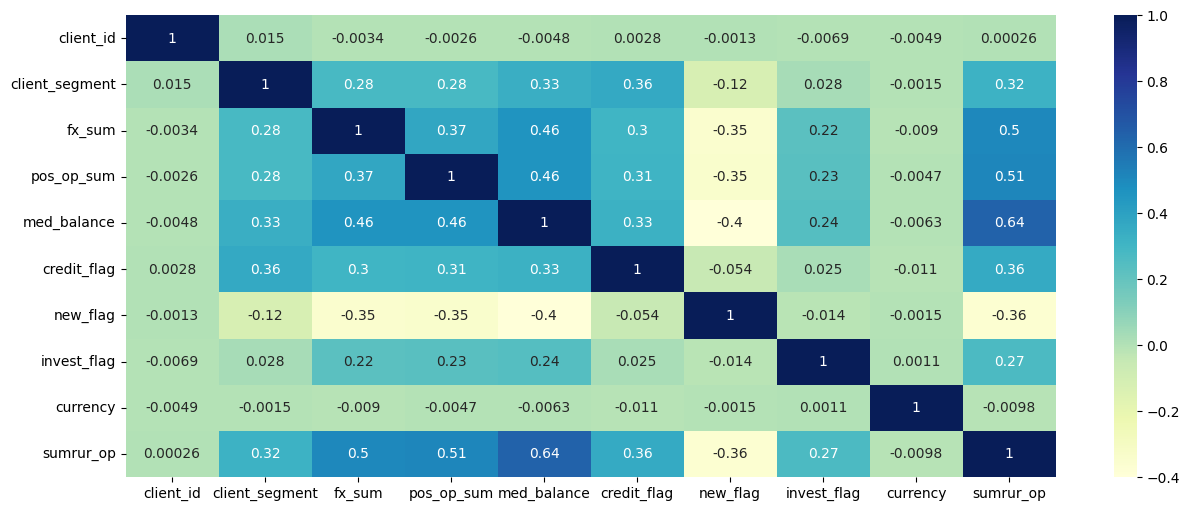

In [38]:
plt.figure(figsize = (15, 6))
sns.heatmap(df.corr(), annot = True, cmap = "YlGnBu")

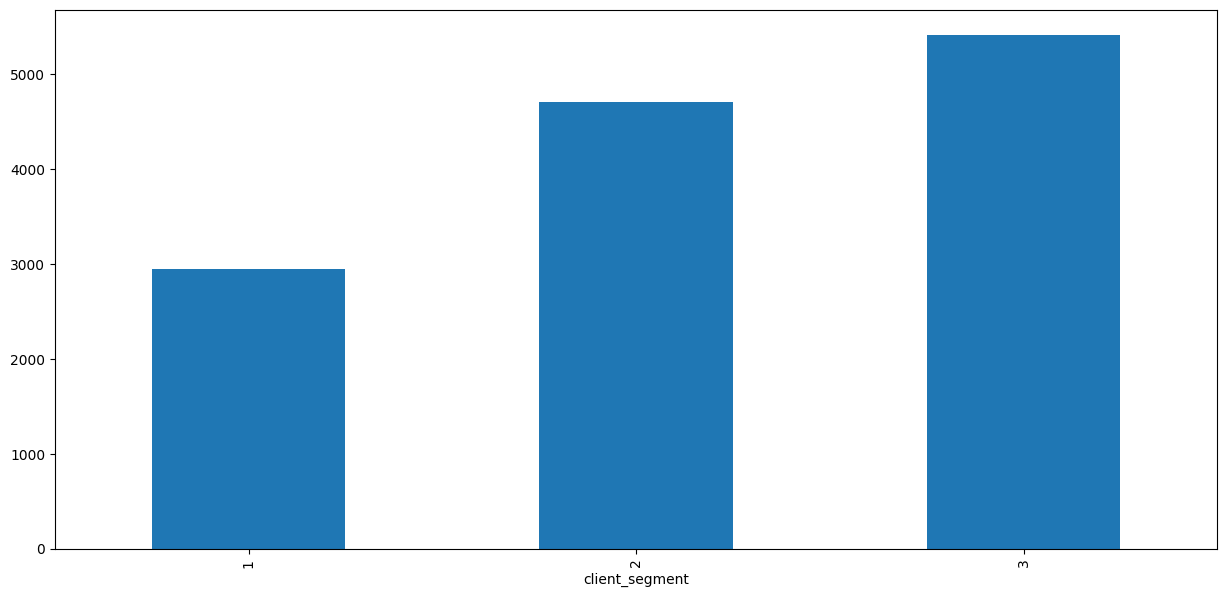

In [39]:
df.groupby("client_segment")["med_balance"].sum().plot(kind = 'bar', figsize=(15,7))
plt.show()

In [41]:
X = df.drop(['sumrur_op', 'client_id'], axis = 1)
y = df['sumrur_op']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
cv_score = np.abs(np.mean(cv_score))
print("Results")
print("MSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("CV Score:", np.sqrt(cv_score))

arr = r2_score(y_test, pred)
print("r2 score:", arr)

Results
MSE: 0.16657488734598083
CV Score: 0.16736492750159362
r2 score: 0.5168883681339587


<Axes: title={'center': 'Model Coefficients'}>

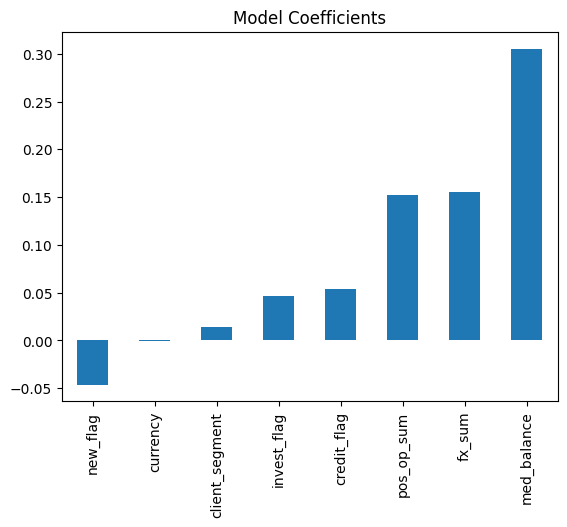

In [43]:
coef = pd.Series(model.coef_, X_test.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

In [44]:
# Метод опорных векторов
svm_model = SVR(kernel="linear")
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_mse = mean_squared_error(y_test, svm_pred)
svm_r2 = r2_score(y_test, svm_pred)
print("Метод опорных векторов:")
print("Средняя квадратичная ошибка (MSE):", svm_mse)
print("Коэффициент детерминации (R^2):", svm_r2)

Метод опорных векторов:
Средняя квадратичная ошибка (MSE): 0.027998729581828894
Коэффициент детерминации (R^2): 0.5125088187309552


In [45]:
gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train, y_train.ravel())
gb_pred = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)
print("Градиентный бустинг:")
print("Средняя квадратичная ошибка (MSE):", gb_mse)
print("Коэффициент детерминации (R^2):", gb_r2)

Градиентный бустинг:
Средняя квадратичная ошибка (MSE): 0.02502639608757164
Коэффициент детерминации (R^2): 0.5642606799004493


<Axes: title={'center': 'Model Coefficients'}>

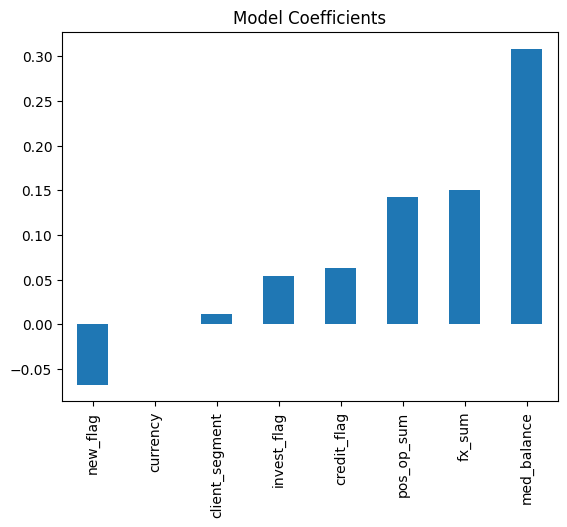

In [48]:

coef = pd.Series(svm_model.coef_[0], svm_model.feature_names_in_).sort_values()
coef.plot(kind='bar', title='Model Coefficients')